In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
! pip install datasets transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import transformers
print(transformers.__version__)

import pickle

4.21.3


In [74]:
task_path = '/content/drive/My Drive/Supernova-NLP/intent classification/intent classification'
max_length = 128

## Loading the dataset

In [75]:
import datasets
from datasets import load_metric
from datasets import DatasetDict, Dataset, ClassLabel
import pandas as pd
import matplotlib.pyplot as plt

[link text](https://)Read sentences from excel

In [76]:
df_sentences = pd.read_excel(f'{task_path}/topic-data.xlsx')[["INTENT", "SENTENCES"]]
df_sentences = df_sentences.loc[pd.notnull(df_sentences['INTENT'])]

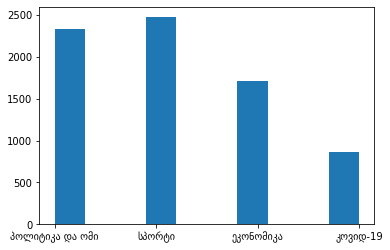

In [77]:
fig = plt.figure()
ax = fig.subplots()
ax.hist(df_sentences['INTENT'])
plt.show()

Make datasets.Dataset object and split into two sets

In [78]:
classes = list(pd.unique(df_sentences['INTENT']))
classLabel = ClassLabel(num_classes=len(classes), names=classes)

In [79]:
with open(f'{task_path}/models/classLabel.pickle', 'wb') as handle:
    pickle.dump(classLabel, handle)

In [80]:
dataset = Dataset.from_dict({'sentence':df_sentences['SENTENCES'], 'label':classLabel.str2int(df_sentences['INTENT']), 'idx':df_sentences.index})

In [81]:
dataset = dataset.class_encode_column('label')

Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [82]:
train_size = 0.9
dataset = dataset.train_test_split(train_size=train_size)

In [83]:
dataset['train'], dataset['test']

(Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 6632
 }), Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 737
 }))

In [84]:
dataset['test'][1]

{'sentence': 'ვინ შეასრულებს თერთმეტმეტრიანებს "კვარა" თუ ოსიმენი? - ნეაპოლური გამოცემის ვრცელი ანალიზი',
 'label': 1,
 'idx': 3539}

Load Metric. The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [85]:
metric = load_metric("accuracy")

In [86]:
metric

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = datasets.load_metric("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

   

## Preprocessing the data

Import tokenizer for XLM-Roberta

In [87]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')#, use_fast=True)

loading file https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
loading file https://huggingface.co/xlm-roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.dfaaaedc7c1c475302398f09706cbb21e23951b73c6e2b3162c1c8a99bb3b62a
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attenti

You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
#tokenizer("Hello, this one sentence!", "And this sentence goes with it.", truncation=True)

Do all preproccessing with this function.

In [88]:
def preprocess_function(examples):
    # All sentences will be padded ot truncated to max_length
    return tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=max_length)

In [89]:
encoded_dataset = dataset.map(preprocess_function, batched=True, load_from_cache_file=False)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [90]:
encoded_dataset.set_format(type = 'torch', device=device)

## Fine-tuning the model

Import Model and Trainer

In [91]:
from transformers import TrainingArguments, Trainer
from transformers import XLMRobertaForSequenceClassification, XLMRobertaConfig

config = XLMRobertaConfig.from_pretrained('xlm-roberta-base')
config.num_labels = classLabel.num_classes

loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.dfaaaedc7c1c475302398f09706cbb21e23951b73c6e2b3162c1c8a99bb3b62a
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



In [92]:
model = XLMRobertaForSequenceClassification(config)
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [93]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [95]:
metric_name = "accuracy"
batch_size = 16

args = TrainingArguments(
    f"{task_path}/models",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=8,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    report_to='wandb'
)

PyTorch: setting up devices


In [96]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [97]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [98]:
wandb.init(project="intent-classification", entity="orkhanshamil")

eval/accuracy,▁▄▆█▇
eval/loss,▇▅▃▁█
eval/runtime,█▂▄▁▁
eval/samples_per_second,▁▇▅██
eval/steps_per_second,▁▇▅██
train/epoch,▁▁▃▃▅▅▆▇█
train/global_step,▁▁▃▃▅▅▆▇█
train/learning_rate,█▆▃▁
train/loss,█▃▂▁
eval/accuracy,0.83469
eval/loss,0.67627


In [99]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6632
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.582800,0.784261
2,0.849300,0.562292,0.805970
3,0.451400,0.499047,0.820896
4,0.328300,0.481011,0.852103
5,0.232600,0.463823,0.877883
6,0.232600,0.554773,0.869742
7,0.172000,0.597392,0.865672
8,0.136700,0.647923,0.862958


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 737
  Batch size = 16
Saving model checkpoint to /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/models/checkpoint-415
Configuration saved in /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/models/checkpoint-415/config.json
Model weights saved in /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/models/checkpoint-415/pytorch_model.bin
tokenizer config file saved in /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/models/checkpoint-415/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/Supernova-NLP/int

TrainOutput(global_step=3320, training_loss=0.3368153664002936, metrics={'train_runtime': 987.6167, 'train_samples_per_second': 53.721, 'train_steps_per_second': 3.362, 'total_flos': 3489967707193344.0, 'train_loss': 0.3368153664002936, 'epoch': 8.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [100]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 737
  Batch size = 16


{'eval_loss': 0.46382346749305725,
 'eval_accuracy': 0.8778833107191316,
 'eval_runtime': 3.2549,
 'eval_samples_per_second': 226.426,
 'eval_steps_per_second': 14.44,
 'epoch': 8.0}

In [102]:
 trainer.save_model(task_path)

Saving model checkpoint to /content/drive/My Drive/Supernova-NLP/intent classification/intent classification
Configuration saved in /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/config.json
Model weights saved in /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/pytorch_model.bin
tokenizer config file saved in /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/special_tokens_map.json


## Hyperparameter search

The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [ ]:
#@title
# ! pip install optuna
# ! pip install ray[tune]

During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [ ]:
#@title
def model_init():
    config = XLMRobertaConfig.from_pretrained('xlm-roberta-base')
    config.num_labels = classLabel.num_classes
    return XLMRobertaForSequenceClassification(config)

And we can instantiate our `Trainer` like before:

In [ ]:
#@title
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"].shard(index=1, num_shards=5) ,
    eval_dataset=encoded_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.dfaaaedc7c1c475302398f09706cbb21e23951b73c6e2b3162c1c8a99bb3b62a
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
#@title
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [ ]:
#@title
best_run

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
#@title
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

# Demo

In [103]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

Load model, tokenizer and label mapping

In [104]:
model_folder = f'{task_path}'
model = XLMRobertaForSequenceClassification.from_pretrained(model_folder)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_folder)
with open(f'{task_path}/models/classLabel.pickle', 'rb') as handle:
    classLabel = pickle.load(handle)

loading configuration file /content/drive/My Drive/Supernova-NLP/intent classification/intent classification/config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.

In [105]:
dataset['test'][540]

{'sentence': 'მიმდინარე წლის პირველ კვარტალში ქვეყანაში პირდაპირი უცხოური ინვესტიციების 14 % (55.7 მილიონი დოლარი) მშენებლობის სექტორში განხორციელდა.',
 'label': 2,
 'idx': 2126}

Enter sentence here

In [131]:
demo_sentence = "6 სექტემებრის მონაცმებით 2514 ადმიანი დაინფიცირდა"

Tokenize sentence and predict label with model

In [132]:
tokenized = tokenizer(demo_sentence, padding='max_length', truncation=True, max_length=max_length)
input_ids = torch.LongTensor([tokenized['input_ids']])
attention_mask = torch.FloatTensor([tokenized['attention_mask']])

In [31]:
input_ids

tensor([[     0,  11075, 109288,  36764, 105069,  61406, 144947,   1320,      6,
         105195,  11144, 230786,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [32]:
attention_mask

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [33]:
outputs = []
for i,j in input_ids,attention_mask:

  label_idx = model.forward(i,j).logits.argmax()
  outputs.append(label_idx)

ValueError: ignored

In [133]:
label_idx = model.forward(input_ids,attention_mask).logits.argmax()
label_idx

tensor(3)

In [ ]:
for i in 
  label = classLabel.int2str([label_idx])
label

['პოლიტიკა და ომი']

In [134]:
label = classLabel.int2str([label_idx])
label

['კოვიდ-19']